In [1]:
import os
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
import missingno as msno

## For Hire Vehicles

In [ ]:
fhv_sample = pd.read_csv(f'dataset_nyc_taxi_samples/csv/fhv_train_1M.csv')

In [3]:
all_fhv_columns = list(fhv_sample.columns)
all_fhv_columns.remove('tips')
all_fhv_columns.remove('trip_time')
new_order_fhv_columns = ['tips'] + all_fhv_columns + ['trip_time']

In [4]:
fhv_sample = fhv_sample[new_order_fhv_columns]

In [5]:
fhv_sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999967 entries, 0 to 999966
Data columns (total 37 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   tips                       999967 non-null  float64
 1   hvfhs_license_num          999967 non-null  object 
 2   dispatching_base_num       999961 non-null  object 
 3   originating_base_num       724400 non-null  object 
 4   request_datetime           999849 non-null  object 
 5   on_scene_datetime          721421 non-null  object 
 6   pickup_datetime            999967 non-null  object 
 7   dropoff_datetime           999967 non-null  object 
 8   PULocationID               999967 non-null  int64  
 9   DOLocationID               999967 non-null  int64  
 10  trip_miles                 999967 non-null  float64
 11  base_passenger_fare        999967 non-null  float64
 12  tolls                      999967 non-null  float64
 13  bcf                        99

In [6]:
fhv_sample_selection = fhv_sample.drop(columns=['hvfhs_license_num', 'dispatching_base_num', 'originating_base_num',
                                               'wav_match_flag', 'on_scene_datetime', 'airport_fee'])

In [7]:
fhv_sample_selection['request_datetime'] = pd.to_datetime(fhv_sample_selection['request_datetime'])
fhv_sample_selection['pickup_datetime'] = pd.to_datetime(fhv_sample_selection['pickup_datetime'])
fhv_sample_selection['dropoff_datetime'] = pd.to_datetime(fhv_sample_selection['dropoff_datetime'])

In [8]:
fhv_sample_selection['shared_request_flag'] = fhv_sample_selection['shared_request_flag'].map({'Y': 1, 'N': 0})
fhv_sample_selection['shared_match_flag'] = fhv_sample_selection['shared_match_flag'].map({'Y': 1, 'N': 0})
fhv_sample_selection['access_a_ride_flag'] = fhv_sample_selection['access_a_ride_flag'].map({'Y': 1, 'N': 0})
fhv_sample_selection['wav_request_flag'] = fhv_sample_selection['wav_request_flag'].map({'Y': 1, 'N': 0})

In [9]:
fhv_sample_selection.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999967 entries, 0 to 999966
Data columns (total 31 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   tips                       999967 non-null  float64       
 1   request_datetime           999849 non-null  datetime64[ns]
 2   pickup_datetime            999967 non-null  datetime64[ns]
 3   dropoff_datetime           999967 non-null  datetime64[ns]
 4   PULocationID               999967 non-null  int64         
 5   DOLocationID               999967 non-null  int64         
 6   trip_miles                 999967 non-null  float64       
 7   base_passenger_fare        999967 non-null  float64       
 8   tolls                      999967 non-null  float64       
 9   bcf                        999967 non-null  float64       
 10  sales_tax                  999967 non-null  float64       
 11  congestion_surcharge       999418 non-null  float64 

In [10]:
shapefile = gpd.read_file("./taxi_zones")

location_to_borough_mapping = dict(zip(shapefile['LocationID'], shapefile['borough']))
location_to_borough_idx_mapping = dict(zip(shapefile['LocationID'], shapefile['borough'].map({'Manhattan': 0, 'Queens': 1, 'Brooklyn': 2, 'Bronx': 3, 'EWR': 4, 'Staten Island': 5})))

fhv_sample_selection["PULocationBorough"] = fhv_sample_selection['PULocationID'].map(location_to_borough_idx_mapping)
fhv_sample_selection["DOLocationBorough"] = fhv_sample_selection['DOLocationID'].map(location_to_borough_idx_mapping)

In [11]:
fhv_sample_selection

tips    request_datetime     pickup_datetime    dropoff_datetime  \
0        0.0 2019-02-09 08:01:12 2019-02-09 08:08:19 2019-02-09 08:38:14   
1        0.0 2019-02-26 21:59:29 2019-02-26 22:06:47 2019-02-26 22:19:38   
2        0.0 2019-02-08 09:05:02 2019-02-08 09:12:58 2019-02-08 09:34:44   
3        0.0 2019-02-03 23:04:43 2019-02-03 23:11:21 2019-02-03 23:31:54   
4        0.0 2019-02-22 23:08:37 2019-02-22 23:15:33 2019-02-22 23:20:42   
...      ...                 ...                 ...                 ...   
999962   0.0 2023-12-17 00:28:42 2023-12-17 00:37:24 2023-12-17 00:52:31   
999963   0.0 2023-12-10 20:51:14 2023-12-10 20:55:16 2023-12-10 21:17:45   
999964   0.0 2023-12-24 15:11:24 2023-12-24 15:15:27 2023-12-24 15:30:43   
999965   0.0 2023-12-08 22:24:13 2023-12-08 22:26:04 2023-12-08 22:31:51   
999966   0.0 2023-12-13 14:53:48 2023-12-13 14:55:54 2023-12-13 15:04:48   

        PULocationID  DOLocationID  trip_miles  base_passenger_fare  tolls  \
0                 37            62        4.76                 5.46    0.0   
1                113             4        1.41                 5.25    0.0   
2                170           114        2.64                19.12    0.0   
3                164            79        3.63                 4.75    0.0   
4                210           123        1.45                 5.66    0.0   
...              ...           ...         ...                  ...    ...   
999962           262           143        3.36                20.59    0.0   
999963           223           256        8.68                25.03    0.0   
999964           226            56        4.96                19.65    0.0   
999965           220           220        0.95                 7.91    0.0   
999966           125           231        0.95                10.89    0.0   

         bcf  ...  rain (mm)  snowfall (cm)  snow_depth (m)  \
0       0.14  ...        0.0            0.0            0.00   
1       0.16  ...        0.0            0.0            0.00   
2       0.48  ...        1.7            0.0            0.00   
3       0.13  ...        0.0            0.0            0.00   
4       0.14  ...        0.0            0.0            0.02   
...      ...  ...        ...            ...             ...   
999962  0.57  ...        0.0            0.0            0.00   
999963  0.69  ...        3.0            0.0            0.00   
999964  0.54  ...        0.0            0.0            0.00   
999965  0.22  ...        0.0            0.0            0.00   
999966  0.30  ...        0.0            0.0            0.00   

        surface_pressure (hPa)  cloud_cover (%)  wind_speed_10m (km/h)  \
0                       1027.0               10                   20.7   
1                       1024.4               18                   14.8   
2                       1006.7               91                   11.9   
3                       1013.7                1                    8.9   
4                       1024.5               30                    8.9   
...                        ...              ...                    ...   
999962                  1025.8               69                    8.6   
999963                   998.6              100                   29.2   
999964                  1022.5               66                    4.4   
999965                  1017.2               13                    8.4   
999966                  1023.9                0                   16.7   

        is_day ()  trip_time  PULocationBorough  DOLocationBorough  
0               1       1795                2.0                2.0  
1               0        771                0.0                0.0  
2               1       1306                0.0                0.0  
3               0       1233                0.0                0.0  
4               0        309                2.0                2.0  
...           ...        ...                ...                ...  
999962          0        907 

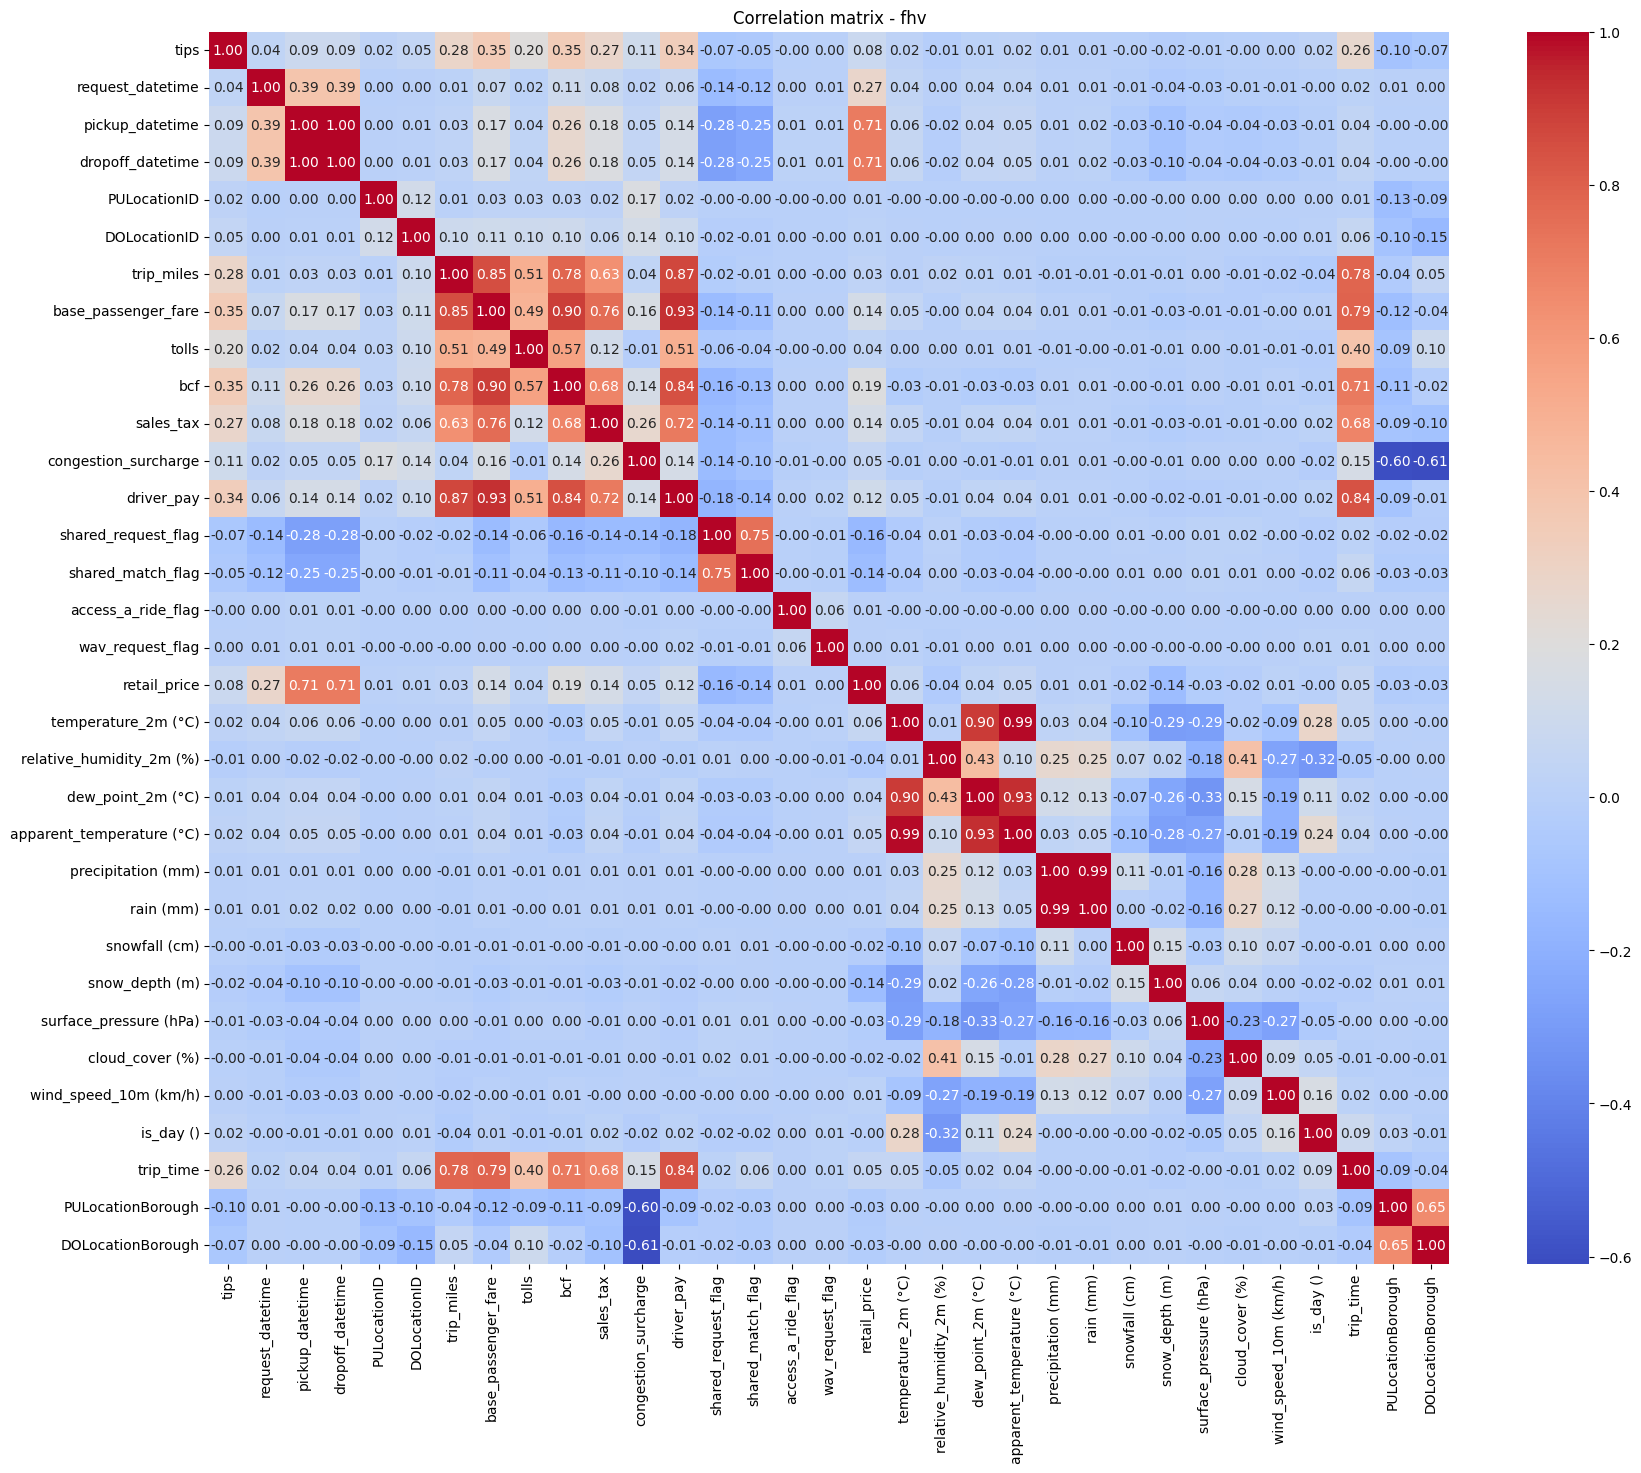

In [12]:
correlation_matrix = fhv_sample_selection.corr()

plt.figure(figsize=(20, 16))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 10})
plt.title('Correlation matrix - fhv')
plt.show()

In [13]:
fhv_sample_selection['wait_time'] = fhv_sample_selection['pickup_datetime'] - fhv_sample_selection['request_datetime']
fhv_sample_selection['wait_time'] = fhv_sample_selection['wait_time'].values.astype(float)//10**9

fhv_sample_selection['total_work_time'] = fhv_sample_selection['dropoff_datetime'] - fhv_sample_selection['request_datetime']
fhv_sample_selection['total_work_time'] = fhv_sample_selection['total_work_time'].values.astype(float)//10**9

In [14]:
fhv_sample_selection['year'] = fhv_sample_selection['pickup_datetime'].dt.year
fhv_sample_selection['month'] = fhv_sample_selection['pickup_datetime'].dt.month
fhv_sample_selection['weekday'] = fhv_sample_selection['pickup_datetime'].dt.weekday
fhv_sample_selection['hour'] = fhv_sample_selection['pickup_datetime'].dt.hour

In [15]:
fhv_sample_selection.drop(columns=['PULocationID','DOLocationID'], inplace=True)

In [16]:
fhv_sample_selection.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999967 entries, 0 to 999966
Data columns (total 37 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   tips                       999967 non-null  float64       
 1   request_datetime           999849 non-null  datetime64[ns]
 2   pickup_datetime            999967 non-null  datetime64[ns]
 3   dropoff_datetime           999967 non-null  datetime64[ns]
 4   trip_miles                 999967 non-null  float64       
 5   base_passenger_fare        999967 non-null  float64       
 6   tolls                      999967 non-null  float64       
 7   bcf                        999967 non-null  float64       
 8   sales_tax                  999967 non-null  float64       
 9   congestion_surcharge       999418 non-null  float64       
 10  driver_pay                 999967 non-null  float64       
 11  shared_request_flag        999967 non-null  int64   

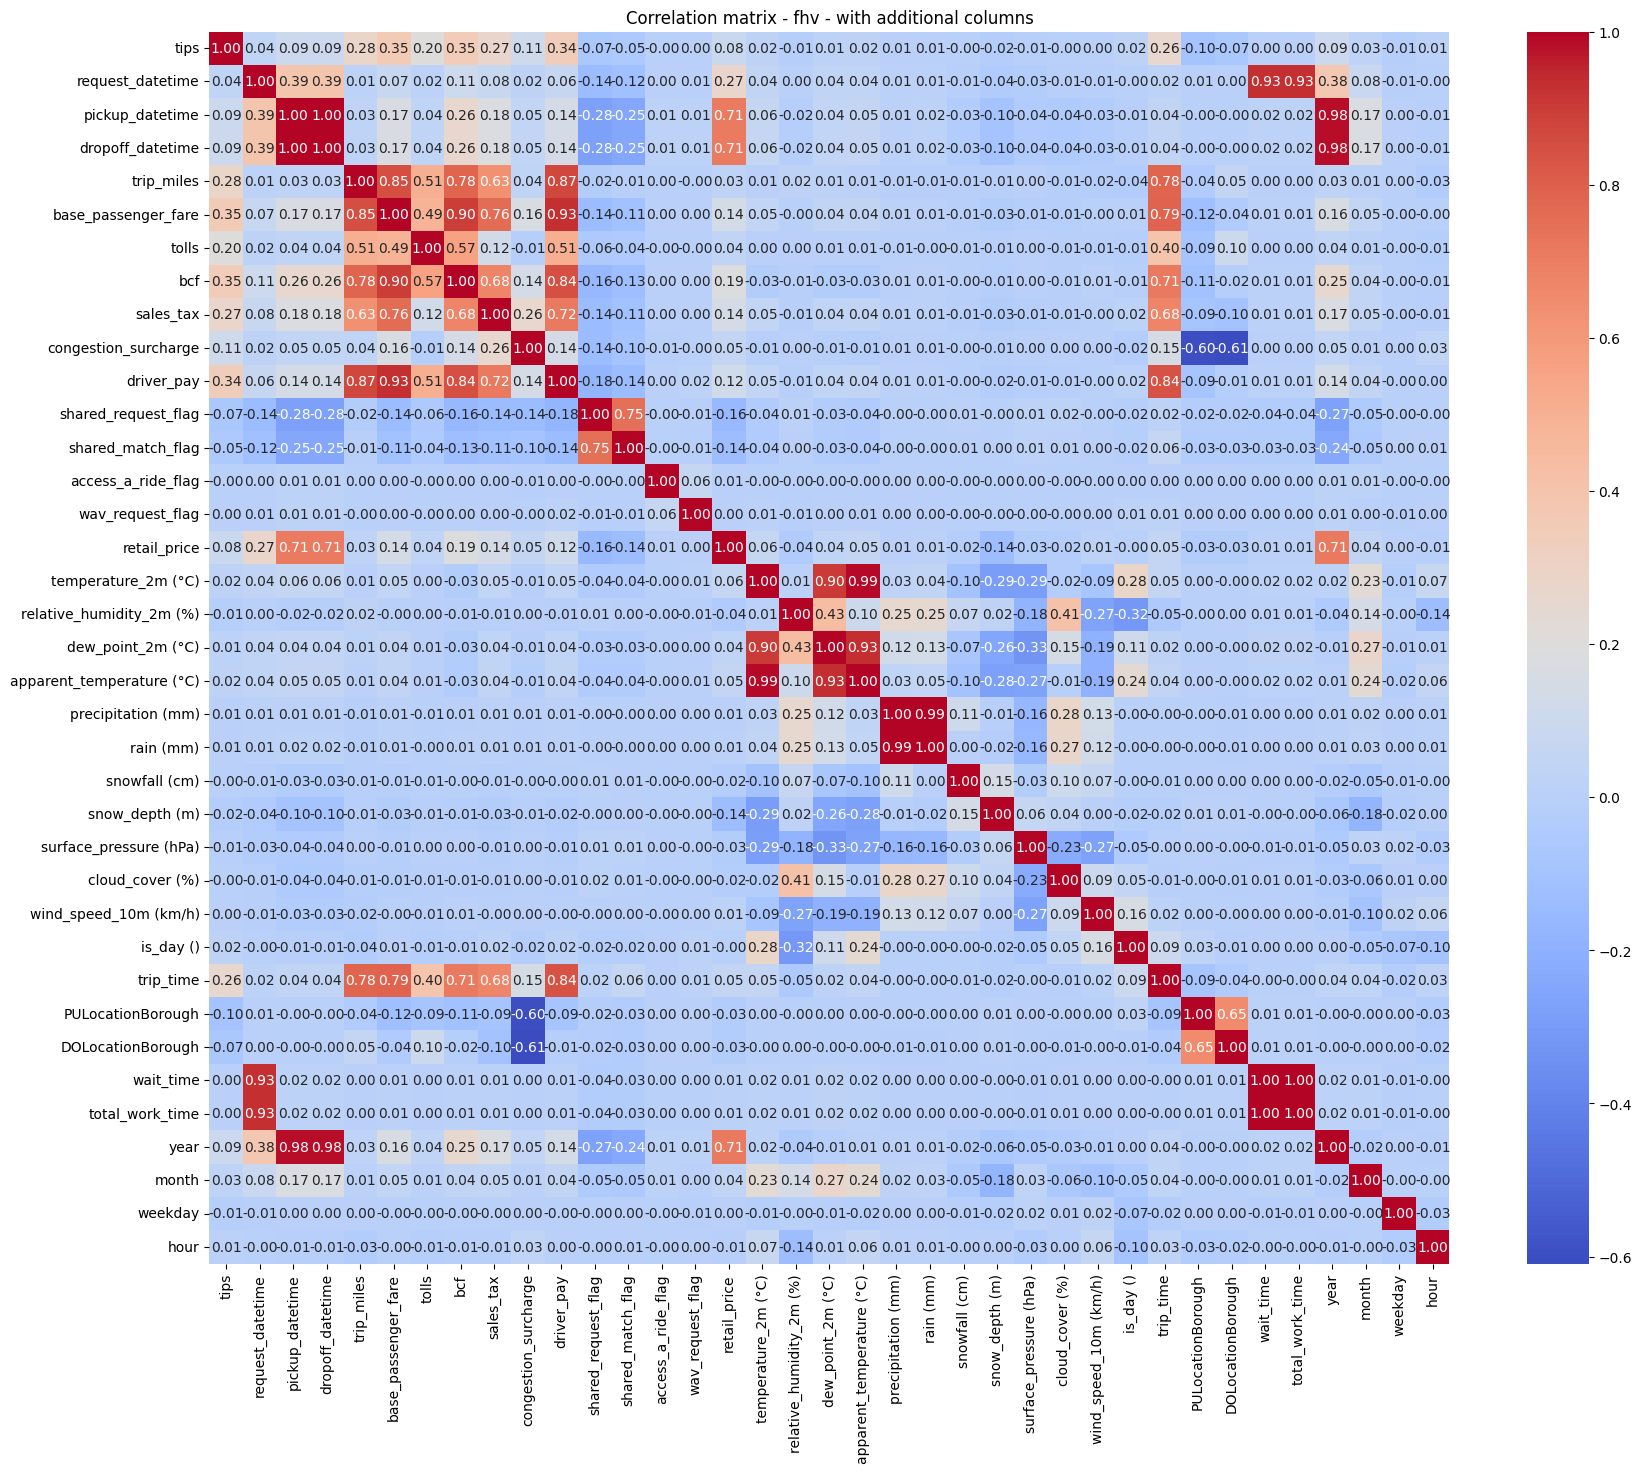

In [17]:
correlation_matrix = fhv_sample_selection.corr()

plt.figure(figsize=(20, 16))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 10})
plt.title('Correlation matrix - fhv - with additional columns')
plt.show()

## Green taxi

In [18]:
green_sample = pd.read_csv(f'dataset_nyc_taxi_samples/csv/green_train_1M.csv')

green_sample_selection = green_sample[['tip_amount', 'VendorID', 'lpep_pickup_datetime', 'lpep_dropoff_datetime',
       'store_and_fwd_flag', 'RatecodeID', 'PULocationID', 'DOLocationID',
       'passenger_count', 'trip_distance', 'fare_amount', 'extra', 
       'tolls_amount', 'improvement_surcharge',
       'total_amount', 'trip_type', 'congestion_surcharge',
       'retail_price', 'temperature_2m (°C)', 'relative_humidity_2m (%)',
       'apparent_temperature (°C)', 'rain (mm)', 'snowfall (cm)', 'snow_depth (m)',
       'surface_pressure (hPa)', 'cloud_cover (%)', 'wind_speed_10m (km/h)',
       'is_day ()']].copy()

In [19]:
green_sample_selection["PULocationBorough"] = green_sample_selection['PULocationID'].map(location_to_borough_idx_mapping)
green_sample_selection["DOLocationBorough"] = green_sample_selection['DOLocationID'].map(location_to_borough_idx_mapping)

In [20]:
green_sample_selection["store_and_fwd_flag"] = green_sample_selection["store_and_fwd_flag"].map({'Y': 1, 'N': 0})

In [21]:
green_sample_selection['lpep_pickup_datetime'] = pd.to_datetime(green_sample_selection['lpep_pickup_datetime'])
green_sample_selection['lpep_dropoff_datetime'] = pd.to_datetime(green_sample_selection['lpep_dropoff_datetime'])

In [22]:
green_sample_selection.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999970 entries, 0 to 999969
Data columns (total 30 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   tip_amount                 999970 non-null  float64       
 1   VendorID                   999970 non-null  int64         
 2   lpep_pickup_datetime       999970 non-null  datetime64[ns]
 3   lpep_dropoff_datetime      999970 non-null  datetime64[ns]
 4   store_and_fwd_flag         999970 non-null  int64         
 5   RatecodeID                 999970 non-null  float64       
 6   PULocationID               999970 non-null  int64         
 7   DOLocationID               999970 non-null  int64         
 8   passenger_count            999970 non-null  float64       
 9   trip_distance              999970 non-null  float64       
 10  fare_amount                999970 non-null  float64       
 11  extra                      999970 non-null  float64 

In [23]:
green_sample_selection.dropna(inplace=True)

In [24]:
green_sample_selection.info()

<class 'pandas.core.frame.DataFrame'>
Index: 989223 entries, 0 to 999969
Data columns (total 30 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   tip_amount                 989223 non-null  float64       
 1   VendorID                   989223 non-null  int64         
 2   lpep_pickup_datetime       989223 non-null  datetime64[ns]
 3   lpep_dropoff_datetime      989223 non-null  datetime64[ns]
 4   store_and_fwd_flag         989223 non-null  int64         
 5   RatecodeID                 989223 non-null  float64       
 6   PULocationID               989223 non-null  int64         
 7   DOLocationID               989223 non-null  int64         
 8   passenger_count            989223 non-null  float64       
 9   trip_distance              989223 non-null  float64       
 10  fare_amount                989223 non-null  float64       
 11  extra                      989223 non-null  float64      

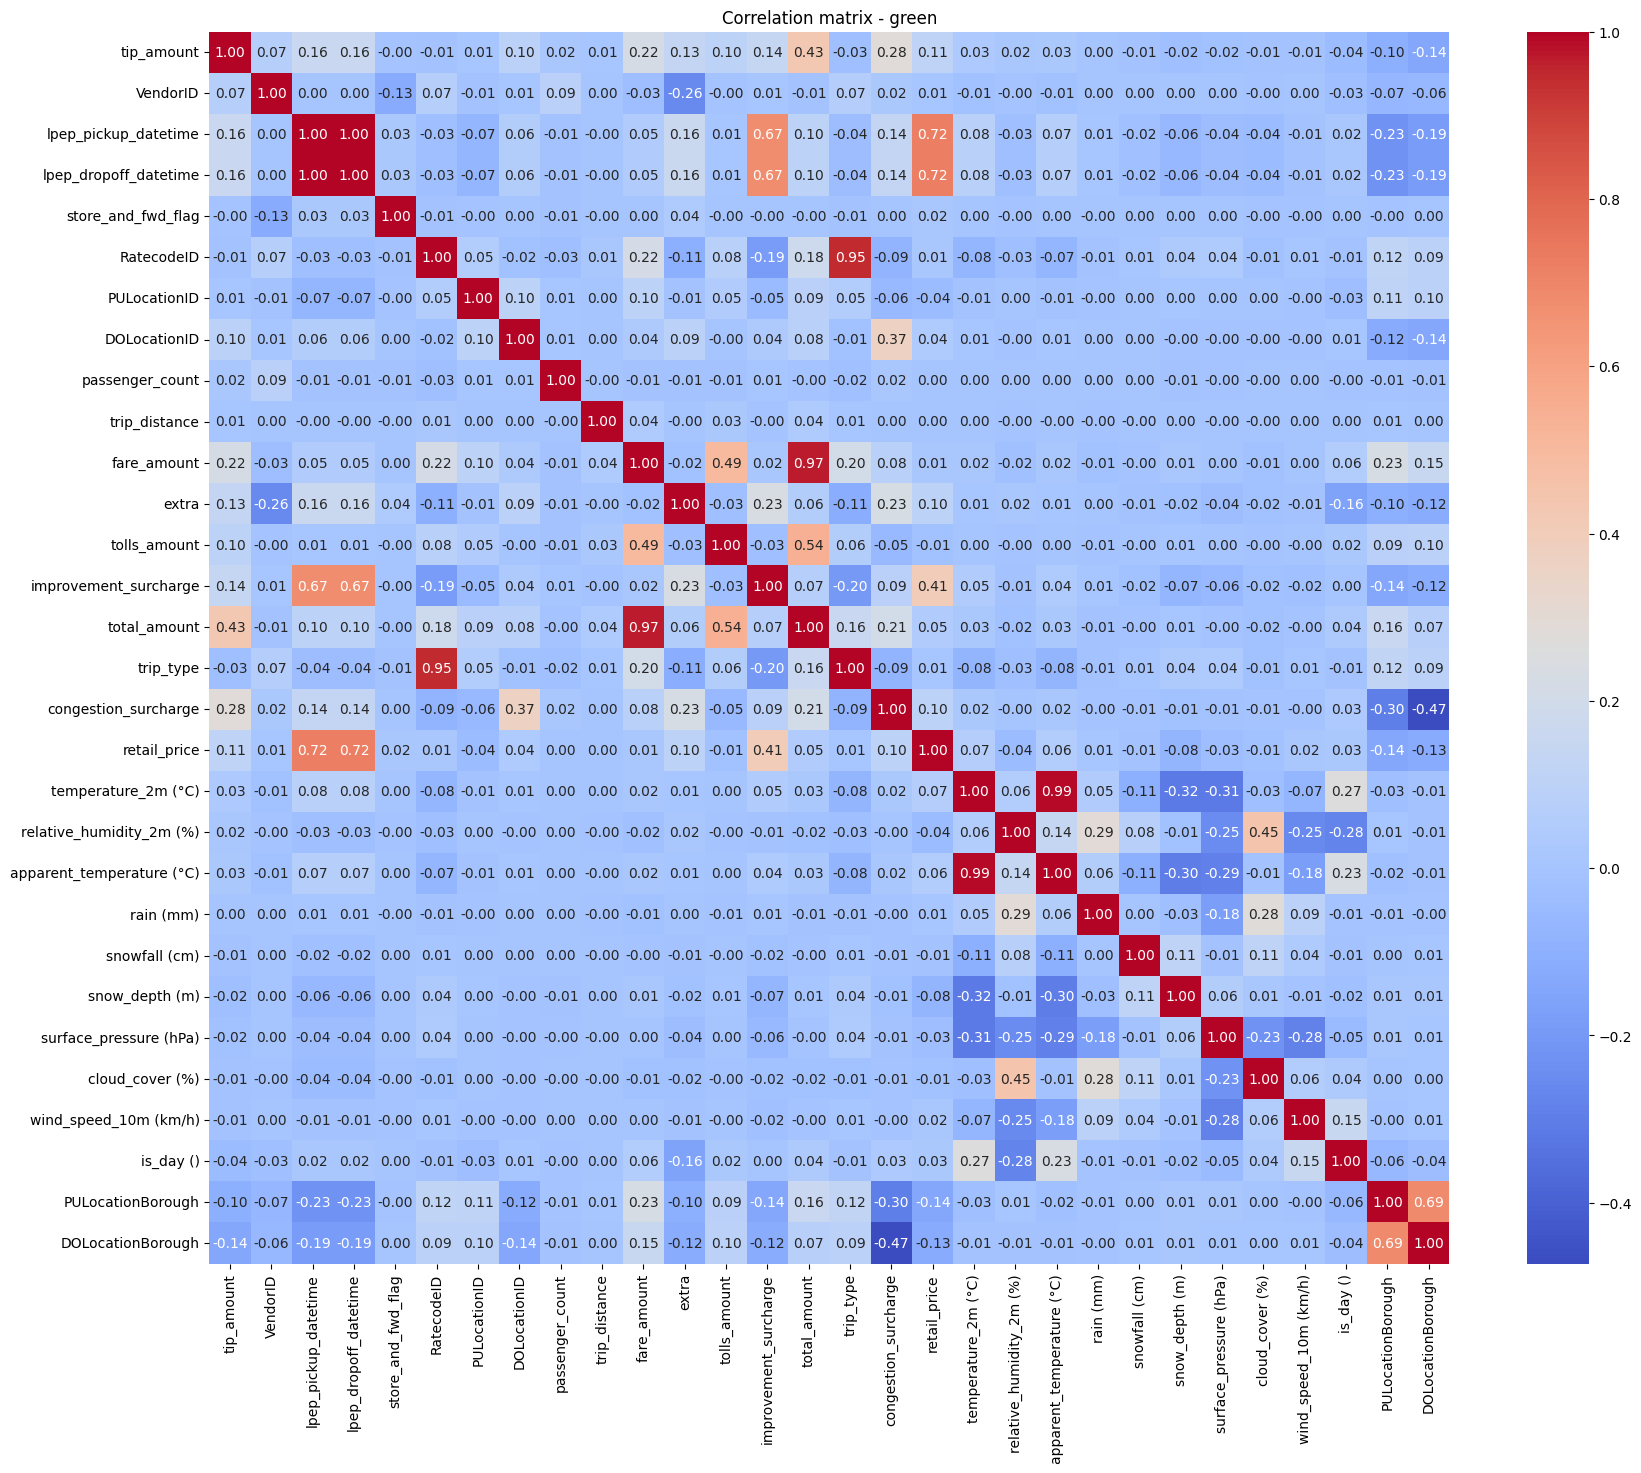

In [25]:
correlation_matrix = green_sample_selection.corr()

plt.figure(figsize=(20, 16))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 10})
plt.title('Correlation matrix - green')
plt.show()

In [26]:
green_sample_selection['year'] = green_sample_selection['lpep_pickup_datetime'].dt.year
green_sample_selection['month'] = green_sample_selection['lpep_pickup_datetime'].dt.month
green_sample_selection['weekday'] = green_sample_selection['lpep_pickup_datetime'].dt.weekday
green_sample_selection['hour'] = green_sample_selection['lpep_pickup_datetime'].dt.hour
green_sample_selection['trip_time'] = green_sample_selection['lpep_dropoff_datetime'] - green_sample_selection['lpep_pickup_datetime'] 
green_sample_selection.info()

<class 'pandas.core.frame.DataFrame'>
Index: 989223 entries, 0 to 999969
Data columns (total 35 columns):
 #   Column                     Non-Null Count   Dtype          
---  ------                     --------------   -----          
 0   tip_amount                 989223 non-null  float64        
 1   VendorID                   989223 non-null  int64          
 2   lpep_pickup_datetime       989223 non-null  datetime64[ns] 
 3   lpep_dropoff_datetime      989223 non-null  datetime64[ns] 
 4   store_and_fwd_flag         989223 non-null  int64          
 5   RatecodeID                 989223 non-null  float64        
 6   PULocationID               989223 non-null  int64          
 7   DOLocationID               989223 non-null  int64          
 8   passenger_count            989223 non-null  float64        
 9   trip_distance              989223 non-null  float64        
 10  fare_amount                989223 non-null  float64        
 11  extra                      989223 non-null  

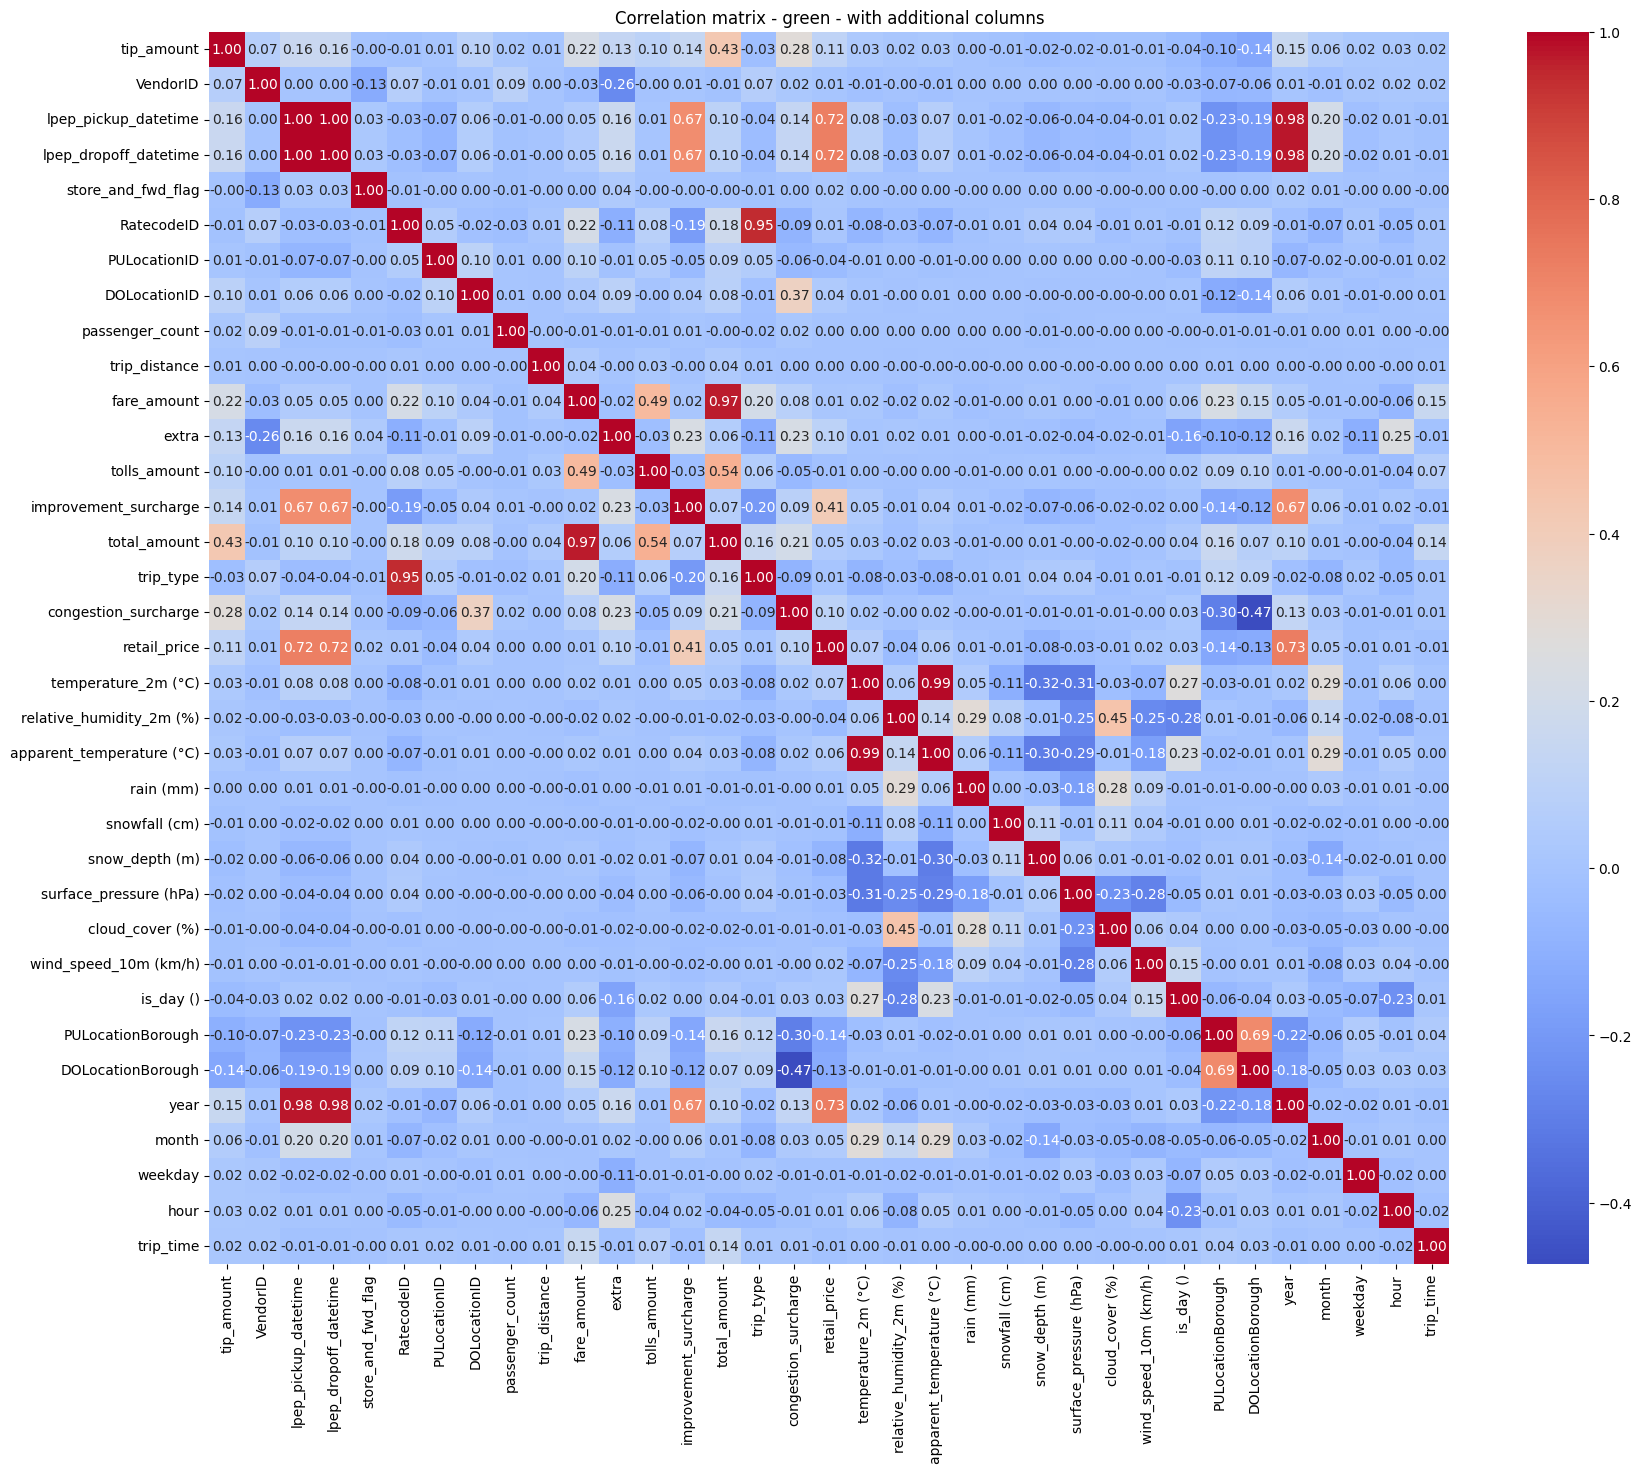

In [27]:
correlation_matrix = green_sample_selection.corr()

plt.figure(figsize=(20, 16))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 10})
plt.title('Correlation matrix - green - with additional columns')
plt.show()

## Yellow taxi

In [28]:
yellow_sample = pd.read_csv(f'dataset_nyc_taxi_samples/csv/yellow_train_1M.csv')

yellow_sample_selection = yellow_sample[['tip_amount', 'VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'fare_amount', 'extra',
       'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge', 'retail_price',
       'temperature_2m (°C)', 'relative_humidity_2m (%)',
       'apparent_temperature (°C)', 'rain (mm)',
       'snowfall (cm)', 'snow_depth (m)', 'surface_pressure (hPa)',
       'cloud_cover (%)', 'wind_speed_10m (km/h)', 'is_day ()']].copy()

In [29]:
yellow_sample_selection.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999969 entries, 0 to 999968
Data columns (total 27 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   tip_amount                 999969 non-null  float64
 1   VendorID                   999969 non-null  int64  
 2   tpep_pickup_datetime       999969 non-null  object 
 3   tpep_dropoff_datetime      999969 non-null  object 
 4   passenger_count            999969 non-null  float64
 5   trip_distance              999969 non-null  float64
 6   RatecodeID                 999969 non-null  float64
 7   store_and_fwd_flag         999969 non-null  object 
 8   PULocationID               999969 non-null  int64  
 9   DOLocationID               999969 non-null  int64  
 10  fare_amount                999969 non-null  float64
 11  extra                      999969 non-null  float64
 12  tolls_amount               999969 non-null  float64
 13  improvement_surcharge      99

In [30]:
yellow_sample_selection["PULocationBorough"] = yellow_sample_selection['PULocationID'].map(location_to_borough_idx_mapping)
yellow_sample_selection["DOLocationBorough"] = yellow_sample_selection['DOLocationID'].map(location_to_borough_idx_mapping)
yellow_sample_selection['tpep_pickup_datetime'] = pd.to_datetime(yellow_sample_selection['tpep_pickup_datetime'])
yellow_sample_selection['tpep_dropoff_datetime'] = pd.to_datetime(yellow_sample_selection['tpep_dropoff_datetime'])

In [31]:
yellow_sample_selection['store_and_fwd_flag'] = yellow_sample_selection["store_and_fwd_flag"].map({'Y': 1, 'N': 0})

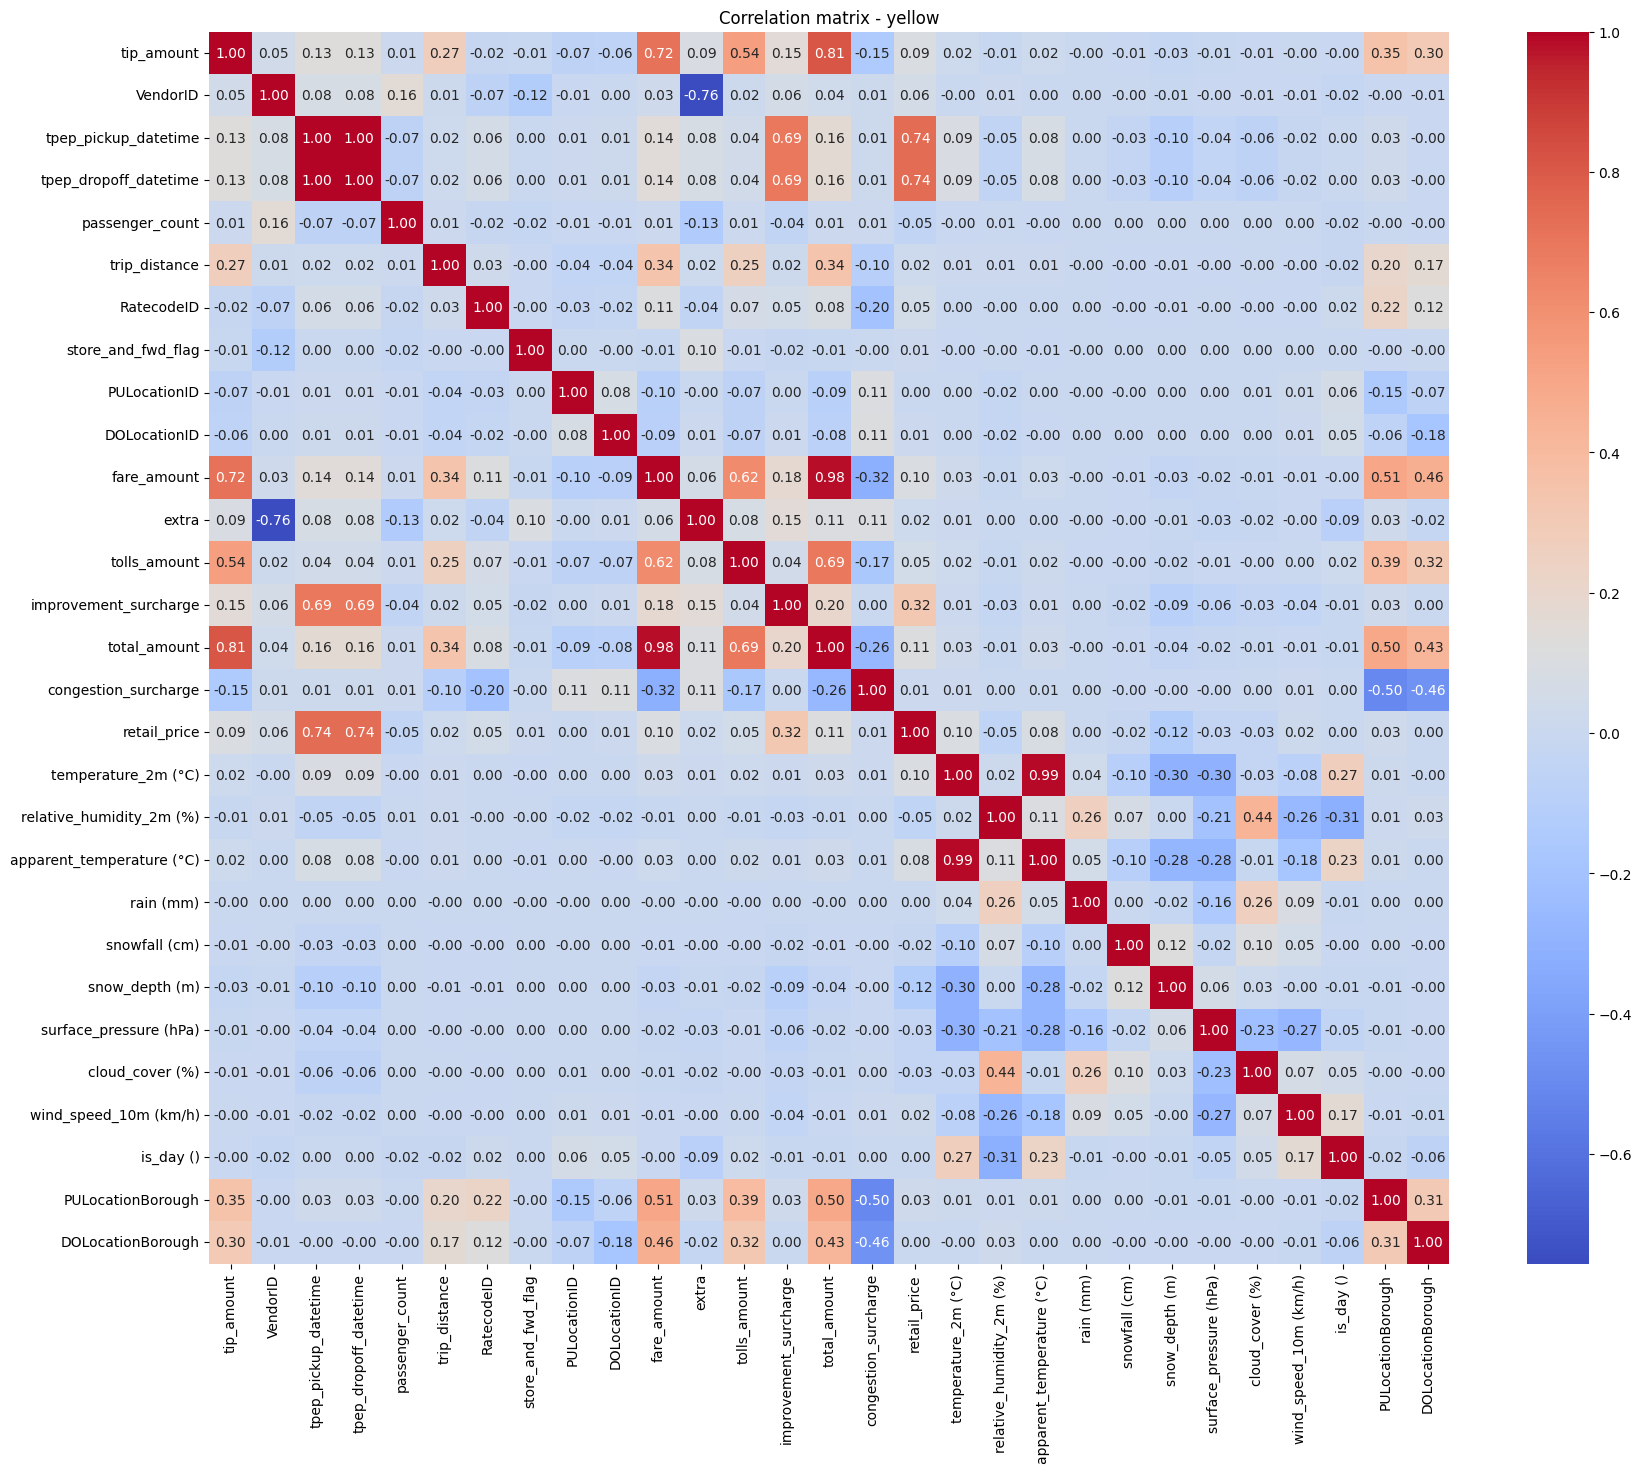

In [32]:
correlation_matrix = yellow_sample_selection.corr()

plt.figure(figsize=(20, 16))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 10})
plt.title('Correlation matrix - yellow')
plt.show()

In [33]:
yellow_sample_selection['year'] = yellow_sample_selection['tpep_pickup_datetime'].dt.year
yellow_sample_selection['month'] = yellow_sample_selection['tpep_pickup_datetime'].dt.month
yellow_sample_selection['weekday'] = yellow_sample_selection['tpep_pickup_datetime'].dt.weekday
yellow_sample_selection['hour'] = yellow_sample_selection['tpep_pickup_datetime'].dt.hour

yellow_sample_selection['trip_time'] = yellow_sample_selection['tpep_dropoff_datetime'] - yellow_sample_selection['tpep_pickup_datetime'] 
yellow_sample_selection.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999969 entries, 0 to 999968
Data columns (total 34 columns):
 #   Column                     Non-Null Count   Dtype          
---  ------                     --------------   -----          
 0   tip_amount                 999969 non-null  float64        
 1   VendorID                   999969 non-null  int64          
 2   tpep_pickup_datetime       999969 non-null  datetime64[ns] 
 3   tpep_dropoff_datetime      999969 non-null  datetime64[ns] 
 4   passenger_count            999969 non-null  float64        
 5   trip_distance              999969 non-null  float64        
 6   RatecodeID                 999969 non-null  float64        
 7   store_and_fwd_flag         999969 non-null  int64          
 8   PULocationID               999969 non-null  int64          
 9   DOLocationID               999969 non-null  int64          
 10  fare_amount                999969 non-null  float64        
 11  extra                      999969 non-n

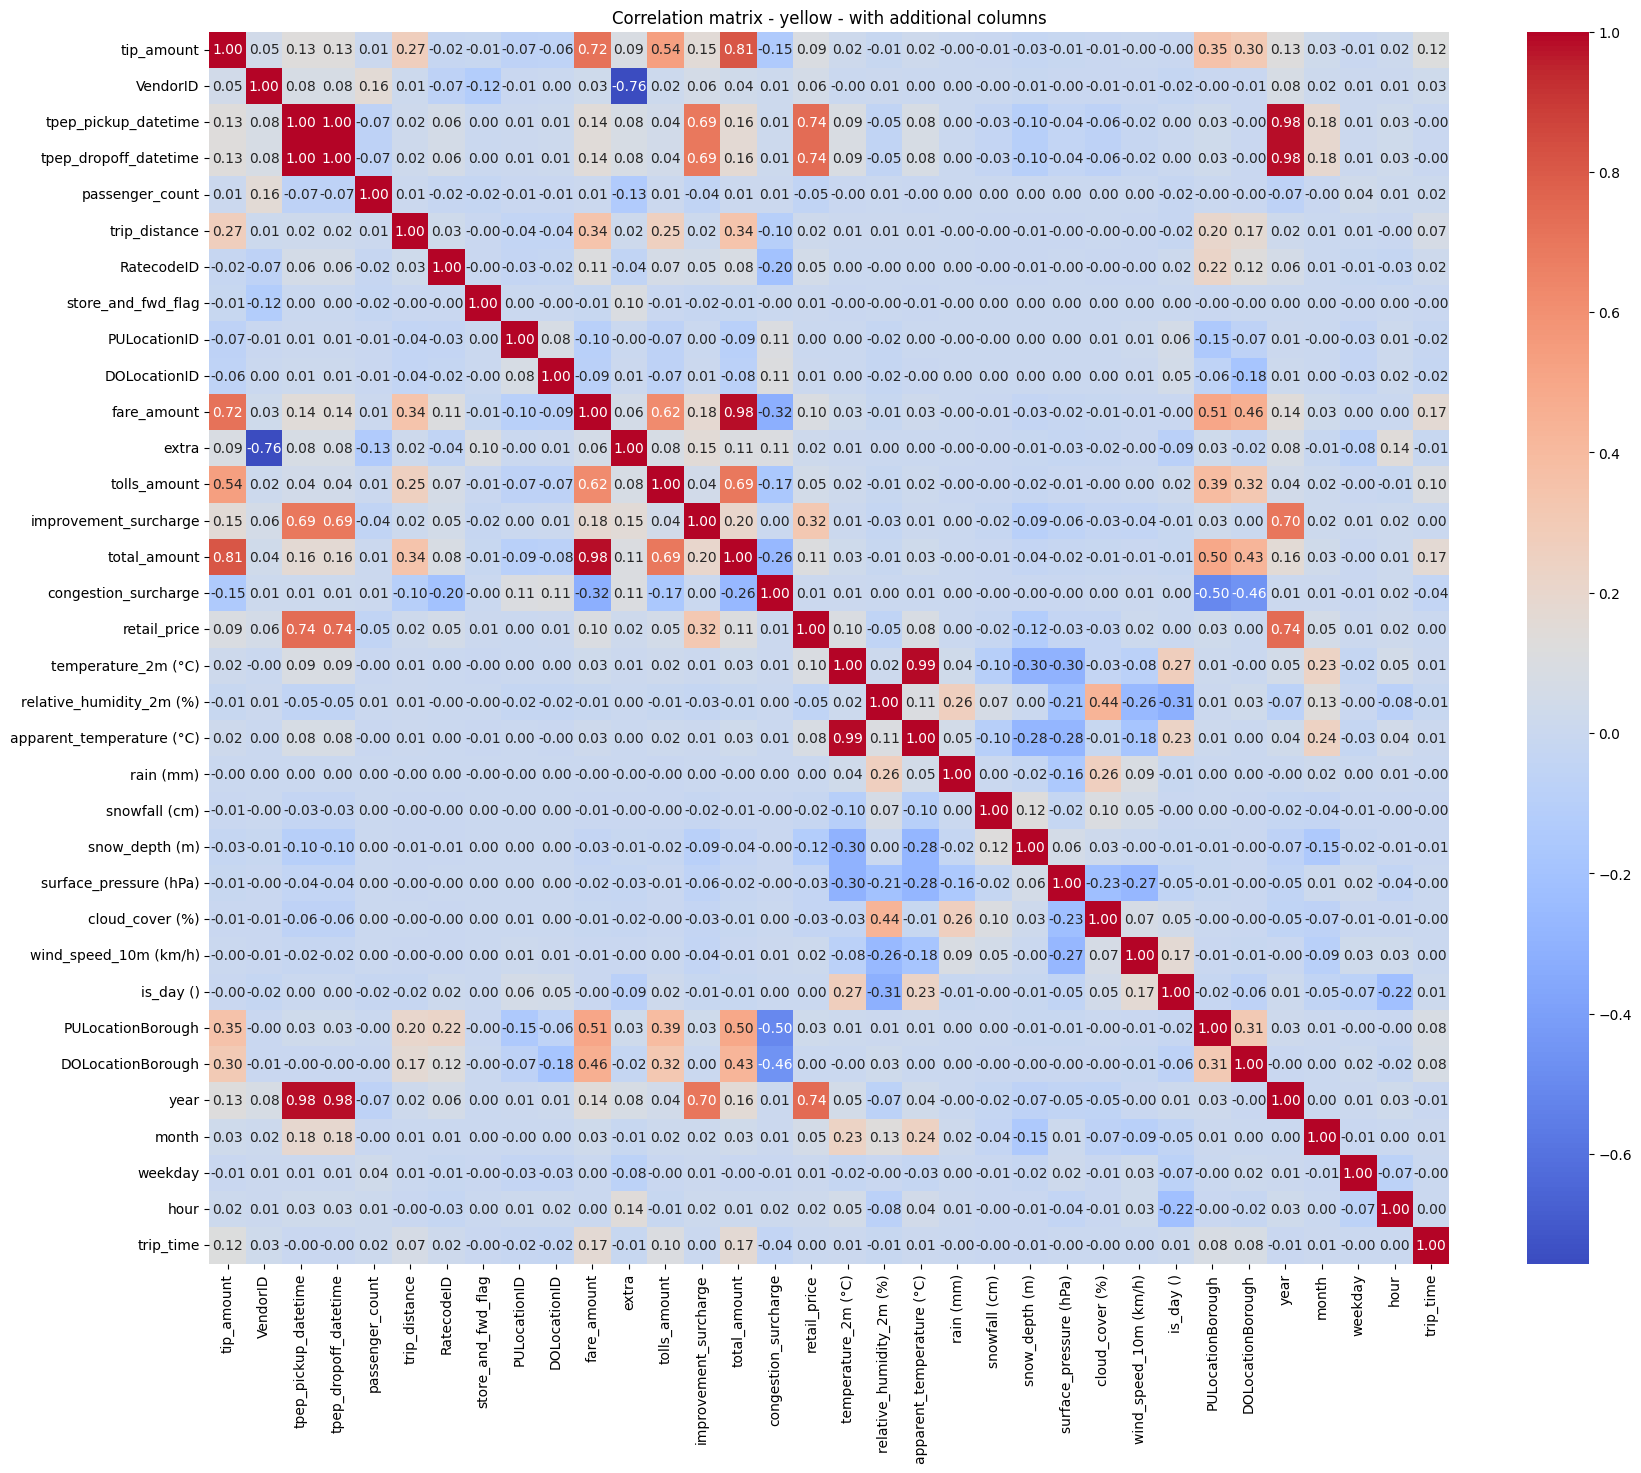

In [34]:
correlation_matrix = yellow_sample_selection.corr()

plt.figure(figsize=(20, 16))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 10})
plt.title('Correlation matrix - yellow - with additional columns')
plt.show()